# Preâmbulo

Imports básicos

In [0]:

# Basic imports.
import os
import time
import numpy as np
import torch

from torch import nn
from torch import optim

from torch.utils.data import DataLoader
from torch.utils import data
from torch.backends import cudnn

from sklearn import metrics

from matplotlib import pyplot as plt
%matplotlib inline

cudnn.benchmark = True

In [0]:
# Setting predefined arguments.
args = {
    'epoch_num': 500,     # Number of epochs.
    'lr': 1e-3,           # Learning rate.
    'weight_decay': 5e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 6,     # Number of workers on data loader.
    'batch_size': 10,     # Mini-batch size.
    'num_samples': 150,   # Number of samples generated
    'sample_size': 500,   # Length of each sample
    'window': 80,         # Input sequence length  ###
    'horizon': 30,        # Output sequence length ###
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
    
}

if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

cuda


In [0]:
# Random initialization for weights and biases.
def initialize_weights(*models):
    for model in models:
        for k, module in enumerate(model.modules()):
            if isinstance(module, nn.RNN):
                for name, param in module.named_parameters():
                  if 'weight' in name:
                    nn.init.xavier_normal_(param.data)
                  elif 'bias' in name:
                    nn.init.constant_(param.data, 0)
            elif isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    module.bias.data.zero_()
            elif isinstance(module, nn.BatchNorm2d):
                module.weight.data.fill_(1)
                module.bias.data.zero_()

# Forecast de séries temporais



## Dados 

Na aula de hoje vamos criar um modelo de sequência na sua forma mais simples, com entradas e saídas de **tamanho fixo**.

Os dados de entrada são senoides com diferentes frequências que treinarão um único modelo. O processo de treinamento terá como entrada um crop aleatório de cada sequência de treino, com o objetivo de prever os pontos num intervalo futuro definido. No dicionário de argumentos foram definidos o tamanho do crop de entrada em **```args['window']```**, e o intervalo futuro a ser predito em **```args['horizon']```**.

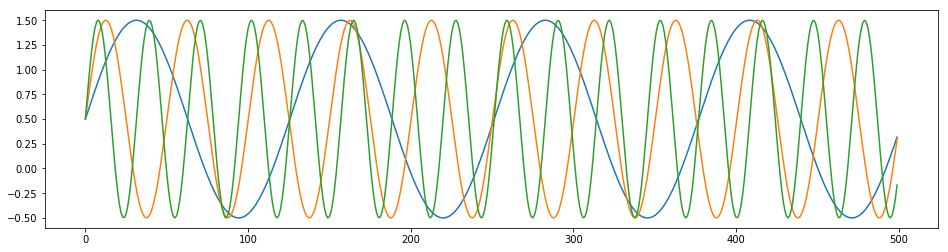

In [0]:
import numpy as np
import random
import matplotlib.pyplot as plt

xtime = np.arange(0, args['sample_size'])

X = [ np.sin(i * xtime) for i in  np.linspace(0.05, 0.2, args['num_samples']) ]

plt.figure(figsize=(16,4))
for i in [0, args['num_samples']//2, -1]:  
  x = X[i]
  x = x - min(x) / (max(x) - min(x))
  
  plt.plot(x)

plt.show()

In [0]:
class SequenceData(data.Dataset):
  
  def __init__(self, num_samples, sample_size, window, horizon):
    
    self.window  = window
    self.horizon = horizon
    self.sample_size = sample_size
    self.num_samples = num_samples
    self.time = torch.arange(0, self.sample_size, dtype=torch.float)
    
    self.data  = [ torch.sin(i * self.time) for i in  np.linspace(0.05, 0.2, self.num_samples) ]
    
  def __getitem__(self, idx):
    
    seq = self.data[idx]
    seq = (seq - min(seq)) / (max(seq) - min(seq))
    
    crop_idx = np.random.choice(np.arange(len(seq) - self.window - self.horizon))
    
    x = seq[crop_idx : crop_idx+self.window]
    y = seq[crop_idx+self.window : crop_idx+self.window+self.horizon]
    
    return x.unsqueeze(-1), y
    
  def __len__(self):
    return len(self.data)
    

# Setting datasets.
train_data = SequenceData(args['num_samples'], args['sample_size'], args['window'], args['horizon'])
test_data  = SequenceData(args['num_samples'], args['sample_size'], args['window'], args['horizon'])

# Randomizing train/test splits
torch.manual_seed(1) # For reproducibility
indices = torch.randperm(len(train_data)).tolist()
dataset = torch.utils.data.Subset(train_data, indices[:-200])
dataset_test = torch.utils.data.Subset(test_data, indices[-200:])

# Setting dataloaders.
train_loader = DataLoader(train_data, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])    
test_loader = DataLoader(test_data, batch_size=args['batch_size'], shuffle=True, num_workers=args['num_workers'])    

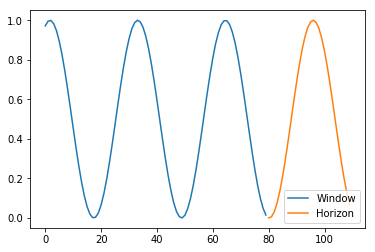

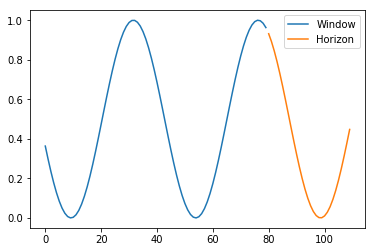

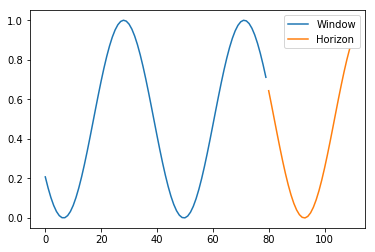

In [0]:
# Plot single sample
for k, (inps, labs) in enumerate(train_loader):
  if k == 3: break
  
  plt.figure()
  
  len_inp = len(inps.data.numpy()[0])
  len_lab = len(labs.data.numpy()[0])
  
  plt.plot(inps.data.numpy()[0], label='Window')
  plt.plot(np.arange(len_inp, len_inp+len_lab),  labs.data.numpy()[0], label='Horizon')
  plt.legend()
  plt.show()

## Tipos de RNN

Relembrando: redes recorrentes podem compor diferentes tipos de modelos. [Um post feito pelo Karpathy](http://karpathy.github.io/2015/05/21/rnn-effectiveness/) sumariza em 5 diferentes modelagens, apresentadas na imagem a seguir.

- **One to One**: Redes feed forward tradicionais, com uma entrada e uma saída.
- **One to Many**: Uma entrada e múltiplas saídas (ex: Image captioning).
- **Many to One**: Entrada sequencial e saída única (ex: análise de sentimentos).
- **Many to Many**: Sequence to sequence não sincronizado (ex: tradução de texto)
- **Many to Many sync**: Sequence to sequence sincronizado, cada elemento da entrada mapeia diretamente para a saída correspondente (ex: sequence labeling).

![](http://karpathy.github.io/assets/rnn/diags.jpeg)


## Backpropagation Through Time (BPTT)

Para explicar a ideia geral da BPTT usaremos a referência [desse post](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/), altamente recomendado para mais detalhes sobre o assunto.

Assuma $E = \{E_0, E_1, ..., E_n\}$ a sequência de erros das saídas produzidas em cada timestep $t = \{0, 1, ..., n\}$. O cálculo do gradiente é feito pelo acúmulo das derivadas de cada erro $E_t$ em relação aos pesos, i.e., $\sum_t \frac{\partial E_t}{\partial W_{hh}}$.  O exemplo a seguir apresenta isoladamente o cálculo de $\frac{\partial E_3}{\partial W_{hh}}$, aplicando a regra da cadeia para derivar o erro $E_3$ em $t=3$ em relação a $W_{hh}$ em $t=0$.

É importante compreender que modelos recorrentes são **profundos na dimensão do tempo**, de modo que o backpropagation na conexão recorrente tem alta propensão aos problemas de **vanishing** e **exploding gradient**. Diferente de redes feed-forward profundas, onde o gradiente só explode ou some nas camadas iniciais, uma única camada recorrente é profunda no tempo, e composta de uma única matriz de pesos. Portanto, **problemas com distribuições complexas e dependências de longo prazo oferecem um grande desafio até para modelos recorrentes de poucas camadas**.

![](http://www.wildml.com/wp-content/uploads/2015/10/rnn-bptt-with-gradients.png)

Nas aulas futuras aprenderemos como contornar o problema do vanishing gradient através do uso de unidades avançadas. Para o exploding gradient, um artifício muito comum é o uso de gradient clipping, apresentado a seguir.

## Gradient Clipping

O clip do gradient nada mais é do que uma norma L2 sobre o gradiente da rede. Define-se uma norma limite na função ```clip_grad_norm_``` do pytorch, que por sua vez já modifica os gradientes caso sua norma total extrapole esse limite. 

Documentação Pytorch: https://www.pydoc.io/pypi/torch.raspi-0.4.0/autoapi/nn/utils/clip_grad/index.html

É importante chamar a função de clipping exatamente após o cálculo dos gradientes, e antes do passo de otimização, como apresentado a seguir.

```python
# Computing backpropagation.
loss.backward()

# Clipping Gradient
torch.nn.utils.clip_grad_norm_(net.parameters(), args['clip_norm'])

# Weight update
optimizer.step()
```



## Atividade Prática

Como o nosso problema possui uma saída de tamanho fixo, podemos modelá-lo como Many to One. Para isso, basta adicionar uma cada Linear, que recebe o hidden state mais significativo (o último da sequência). Essa camada irá realizar a **regressão** do intervalo futuro que queremos prever. A figura a seguir apresenta uma representação visual do que implementaremos a seguir.

![](https://drive.google.com/uc?export=view&id=1yzWthOHPX5jeEgi1OXO81fHBWdXKU6Wq)

Os passos da atividade consistem em:

1.   Implemente a arquitetura proposta, com uma RNN de duas camadas seguida de uma camada Linear.

*  RNN  **Hidden size = 64**
*   Defina **```batch_first=True```** na RNN, visto que a saída do Dataloader organiza o batch na forma ```(batch_size, seq_len, feat_size)```, que não é o padrão da camada RNN.
*   A ativação não linear da RNN é definida internamente. Não há necessidade de camadas de ativação após camadas recorrentes. 
*   A saída da camada Linear corresponde ao argumento **```args['horizon']```** que define o intervalo futuro que se deseja prever.
*   Após a camada Linear, defina uma camada de ativação **sigmóide**, visto que estamos lidando com um problema de regressão.


2.   Implemente o forward da sua rede.
*   Lembre-se que é necessário inicalizar o hidden state a cada forward. 
*   Atenção também para a transição entre a camada recorrente e a Linear, deve-se passar **apenas o último hidden state da sequência** que agrega toda a memória da sequência.

3.   Defina o otimizador e a função de perda de regressão (sugestão: L1). 

4.   Modifique as funções de treino e teste, realizando experimentos sem o gradient clipping, e com diferentes hiperparâmetros de clipping (verifique dicionário de argumentos).
*   Plote os gradientes ao longo das iterações para entender o impacto do clipping.


In [0]:
class RecurrentNet(nn.Module):
  
  def __init__(self, in_size=1, hidden_size=128, num_layers=2, num_directions=1, batch_size=1, horizon=10):
    super(RecurrentNet, self).__init__()
  
    self.hidden_size = hidden_size
    self.num_layers  = num_layers
    self.horizon     = horizon
    self.batch_size  = batch_size
    self.directions  = num_directions


    if self.directions > 1:
        self.rnn = nn.RNN(in_size, hidden_size, num_layers=num_layers, nonlinearity='relu', bidirectional=True, batch_first=True)
    else:
        self.rnn = nn.RNN(in_size, hidden_size, num_layers=num_layers, nonlinearity='relu', bidirectional=False, batch_first=True)    

    self.linear = nn.Linear(hidden_size, horizon)
    self.activation = nn.Sigmoid()
  
  
  def forward(self, x):
    
    hs = torch.zeros(self.num_layers * self.directions, self.batch_size, self.hidden_size ).cuda()
    
    out, hs = self.rnn(x, hs)
    output  = self.activation( self.linear(out[:,-1]) )
    
    return output

net = RecurrentNet(batch_size=args['batch_size'], horizon=args['horizon']).to(args['device'])
initialize_weights(net)
print(net)

RecurrentNet(
  (rnn): RNN(1, 128, num_layers=2, batch_first=True)
  (linear): Linear(in_features=128, out_features=30, bias=True)
  (activation): Sigmoid()
)


In [0]:
# Setting optimizer.
optimizer = optim.Adam(net.parameters(),
                       lr=args['lr'],
                       weight_decay=args['weight_decay'],
                       betas=(args['momentum'], 0.999))

In [0]:
# Setting loss.
criterion = nn.L1Loss().to(args['device'])
# criterion = nn.MSELoss().to(args['device'])

In [0]:
ave_grads, grad_norm, total_norm, trloss = [], [], [], []

def save_grad_flow(named_parameters):

    average = []
    param_norms = []
    
    norm = 0.
    for n, p in named_parameters:
        if(p.requires_grad) and ("bias" not in n):
            average.append(p.grad.abs().mean())
            param_norms.append(p.grad.data.norm(2))
            
            norm += param_norms[-1].item() ** 2
    norm = norm ** (1. / 2)
    
    total_norm.append(norm)
    grad_norm.append(param_norms)
    ave_grads.append(average)

def train(train_loader, net, criterion, optimizer, epoch):

    tic = time.time()
    
    # Setting network for training mode.
    net.train()

    # Lists for losses and metrics.
    train_loss = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(train_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data
        
        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Clears the gradients of optimizer.
        optimizer.zero_grad()

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)

        # Computing backpropagation.
        loss.backward()
        
        # Clipping Gradient
        torch.nn.utils.clip_grad_norm_(net.parameters(), args['clip_norm'])

        # Saving gradient norm
        save_grad_flow(net.named_parameters())
        
        # Weight update
        optimizer.step()
        
        # Updating lists.
        train_loss.append(loss.data.item())
    
    toc = time.time()
    
    train_loss = np.asarray(train_loss)
    trloss.append(train_loss.mean())
    
    # Printing training epoch loss and metrics.
    if epoch % 5 == 0:
      print('--------------------------------------------------------------------')
      print('[epoch %d], [train loss %.4f +/- %.4f], [training time %.2f]' % (
          epoch, train_loss.mean(), train_loss.std(), (toc - tic)))
      print('--------------------------------------------------------------------')
    
def test(test_loader, net, criterion, epoch):

    tic = time.time()
    
    # Setting network for evaluation mode (not computing gradients).
    net.eval()

    # Lists for losses and metrics.
    test_loss = []
    prd_list = []
    lab_list = []
    
    # Iterating over batches.
    for i, batch_data in enumerate(test_loader):

        # Obtaining images, labels and paths for batch.
        inps, labs = batch_data

        # Casting to cuda variables.
        inps = inps.to(args['device'])
        labs = labs.to(args['device'])

        # Forwarding.
        outs = net(inps)

        # Computing loss.
        loss = criterion(outs, labs)
                
        # Updating lists.
        test_loss.append(loss.data.item())
        lab_list.append(labs.detach().cpu().numpy())
        
        if i < 2:
            plt.figure(figsize=(10,4))
            
            inp = inps.cpu().data.numpy()[0]
            lab = labs.cpu().data.numpy()[0]
            out = outs.cpu().data.numpy()[0]
            
            plt.plot(inp, label='Input')
            plt.plot(np.arange(len(inp), len(inp)+len(lab)), lab, label='Label')
            plt.plot(np.arange(len(inp), len(inp)+len(lab)), out, label='Output')
            plt.legend()
            plt.show()
    
    toc = time.time()
    plt.close('all')
    
    # Computing accuracy.
#     acc = metrics.accuracy_score(np.asarray(lab_list).ravel(),
#                                  np.asarray(prd_list).ravel())
    
    test_loss = np.asarray(test_loss)
    tsloss.append(test_loss.mean())
    
    # Printing training epoch loss and metrics.
   
    print('********************************************************************')
    print('[epoch %d], [test loss %.4f +/- %.4f], [testing time %.2f]' % (
        epoch, test_loss.mean(), test_loss.std(), (toc - tic)))
    print('********************************************************************')

--------------------------------------------------------------------
[epoch 5], [train loss 0.2268 +/- 0.0388], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 10], [train loss 0.1705 +/- 0.0291], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 15], [train loss 0.1766 +/- 0.0278], [training time 1.60]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 20], [train loss 0.1685 +/- 0.0331], [training time 1.58]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 25], [train loss 0.1453 +/- 0.0347], [training time 1.59]
-------------------------------------------------------

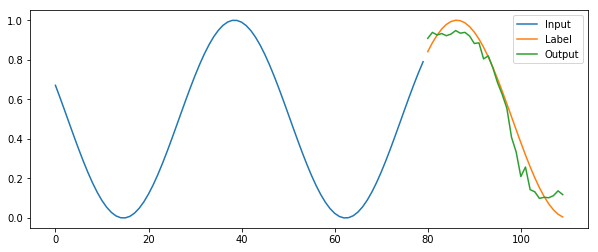

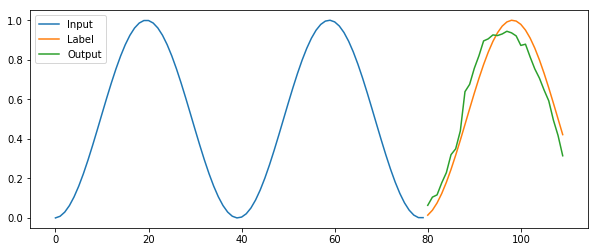

********************************************************************
[epoch 50], [test loss 0.0893 +/- 0.0124], [testing time 2.03]
********************************************************************
--------------------------------------------------------------------
[epoch 55], [train loss 0.0800 +/- 0.0101], [training time 1.57]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 60], [train loss 0.0844 +/- 0.0182], [training time 1.62]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 65], [train loss 0.0790 +/- 0.0131], [training time 1.60]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 70], [train loss 0.0953 +/- 0.0266], [training time 1.57]
--------------------------------------------------------

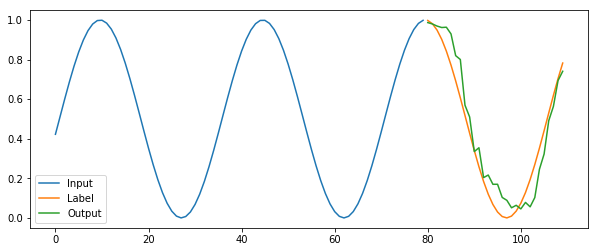

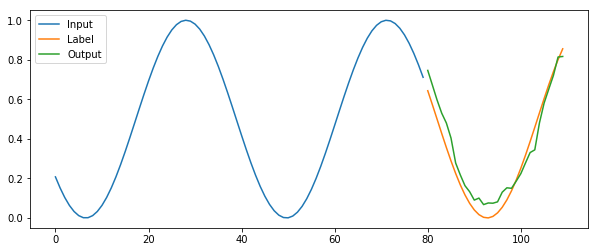

********************************************************************
[epoch 100], [test loss 0.0842 +/- 0.0142], [testing time 2.00]
********************************************************************
--------------------------------------------------------------------
[epoch 105], [train loss 0.0553 +/- 0.0090], [training time 1.60]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 110], [train loss 0.0589 +/- 0.0118], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 115], [train loss 0.0821 +/- 0.0134], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 120], [train loss 0.0898 +/- 0.0240], [training time 1.54]
---------------------------------------------------

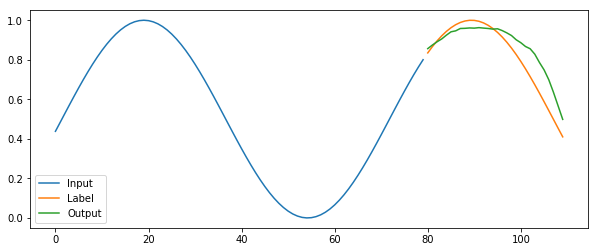

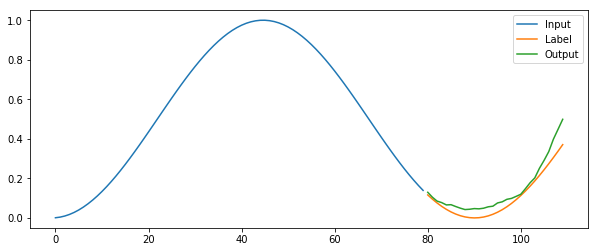

********************************************************************
[epoch 150], [test loss 0.0464 +/- 0.0051], [testing time 1.96]
********************************************************************
--------------------------------------------------------------------
[epoch 155], [train loss 0.0498 +/- 0.0069], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 160], [train loss 0.0471 +/- 0.0086], [training time 1.54]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 165], [train loss 0.1478 +/- 0.0767], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 170], [train loss 0.0518 +/- 0.0103], [training time 1.56]
---------------------------------------------------

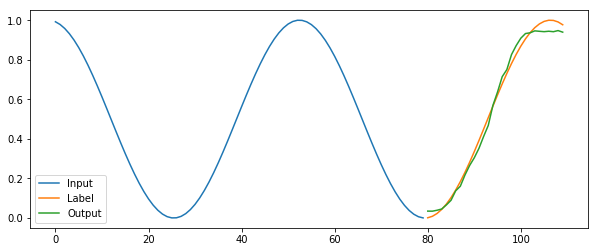

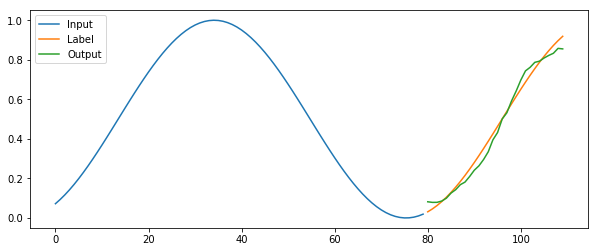

********************************************************************
[epoch 200], [test loss 0.0400 +/- 0.0048], [testing time 1.97]
********************************************************************
--------------------------------------------------------------------
[epoch 205], [train loss 0.0444 +/- 0.0063], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 210], [train loss 0.0394 +/- 0.0055], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 215], [train loss 0.0473 +/- 0.0069], [training time 1.58]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 220], [train loss 0.0415 +/- 0.0068], [training time 1.56]
---------------------------------------------------

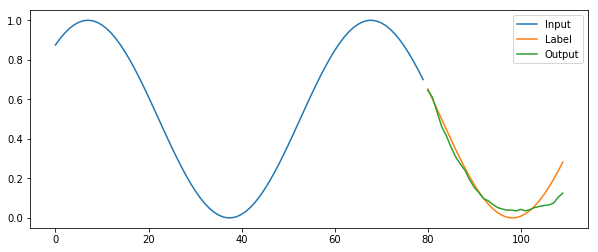

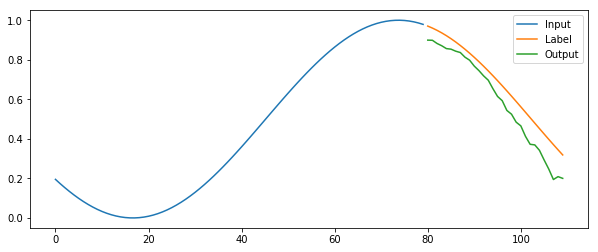

********************************************************************
[epoch 250], [test loss 0.0399 +/- 0.0057], [testing time 2.03]
********************************************************************
--------------------------------------------------------------------
[epoch 255], [train loss 0.0411 +/- 0.0053], [training time 1.57]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 260], [train loss 0.0385 +/- 0.0075], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 265], [train loss 0.0379 +/- 0.0086], [training time 1.58]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 270], [train loss 0.0642 +/- 0.0169], [training time 1.55]
---------------------------------------------------

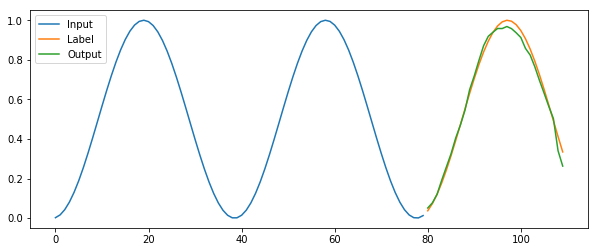

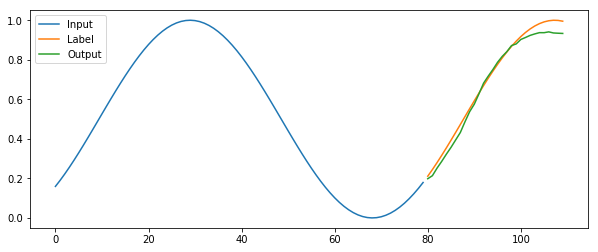

********************************************************************
[epoch 300], [test loss 0.0386 +/- 0.0064], [testing time 1.94]
********************************************************************
--------------------------------------------------------------------
[epoch 305], [train loss 0.0361 +/- 0.0030], [training time 1.54]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 310], [train loss 0.0366 +/- 0.0072], [training time 1.59]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 315], [train loss 0.0440 +/- 0.0113], [training time 1.54]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 320], [train loss 0.0390 +/- 0.0080], [training time 1.57]
---------------------------------------------------

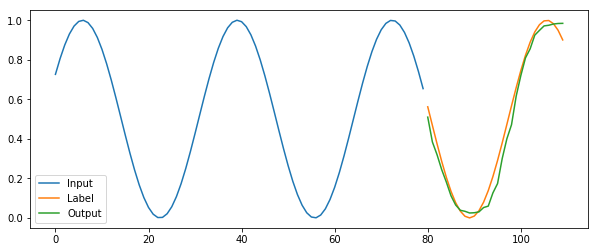

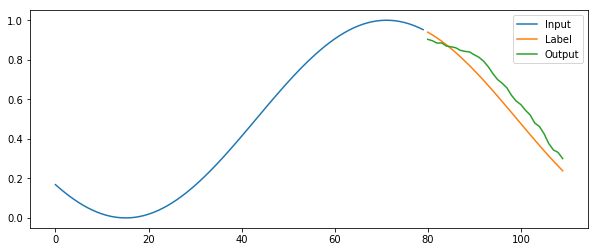

********************************************************************
[epoch 350], [test loss 0.0490 +/- 0.0054], [testing time 1.99]
********************************************************************
--------------------------------------------------------------------
[epoch 355], [train loss 0.0495 +/- 0.0094], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 360], [train loss 0.0402 +/- 0.0072], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 365], [train loss 0.0348 +/- 0.0052], [training time 1.53]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 370], [train loss 0.0300 +/- 0.0047], [training time 1.54]
---------------------------------------------------

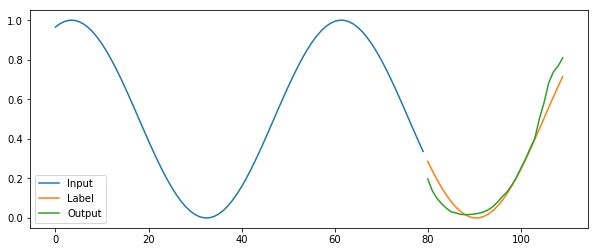

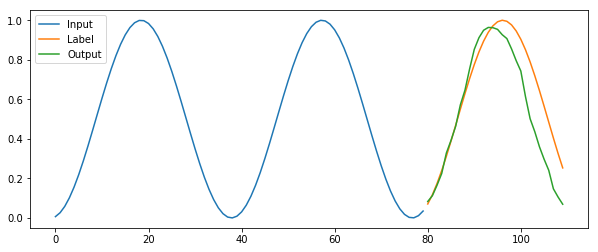

********************************************************************
[epoch 400], [test loss 0.0550 +/- 0.0052], [testing time 1.99]
********************************************************************
--------------------------------------------------------------------
[epoch 405], [train loss 0.0403 +/- 0.0047], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 410], [train loss 0.0405 +/- 0.0150], [training time 1.55]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 415], [train loss 0.0404 +/- 0.0077], [training time 1.60]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 420], [train loss 0.0302 +/- 0.0049], [training time 1.56]
---------------------------------------------------

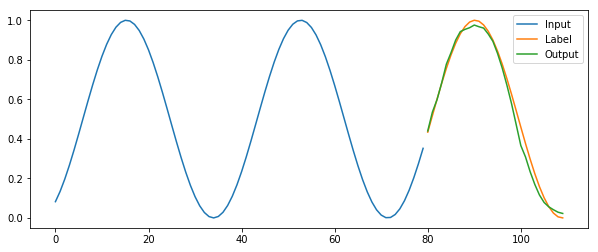

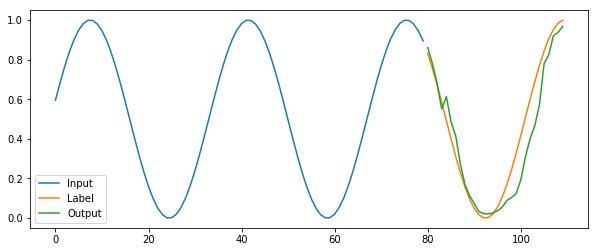

********************************************************************
[epoch 450], [test loss 0.0428 +/- 0.0075], [testing time 2.14]
********************************************************************
--------------------------------------------------------------------
[epoch 455], [train loss 0.0426 +/- 0.0088], [training time 1.60]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 460], [train loss 0.0343 +/- 0.0074], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 465], [train loss 0.0313 +/- 0.0063], [training time 1.56]
--------------------------------------------------------------------
--------------------------------------------------------------------
[epoch 470], [train loss 0.0363 +/- 0.0077], [training time 1.59]
---------------------------------------------------

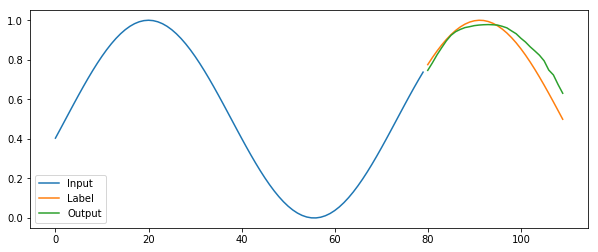

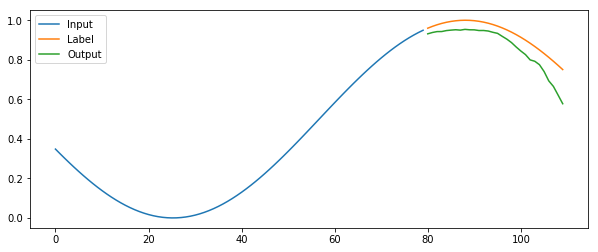

********************************************************************
[epoch 500], [test loss 0.0498 +/- 0.0094], [testing time 1.96]
********************************************************************


In [0]:
# Iterating over epochs.
for epoch in range(1, args['epoch_num'] + 1):

    # Training function.
    train(train_loader, net, criterion, optimizer, epoch)

    # Computing test loss and metrics.
    if epoch % 50 == 0:
      test(test_loader, net, criterion, epoch)

## Visualizando a Norma do Gradiente
Plot da norma do gradiente ao longo do treinamento, junto com o gráfico de convergência do modelo no treino e no teste.

### Clip 6.

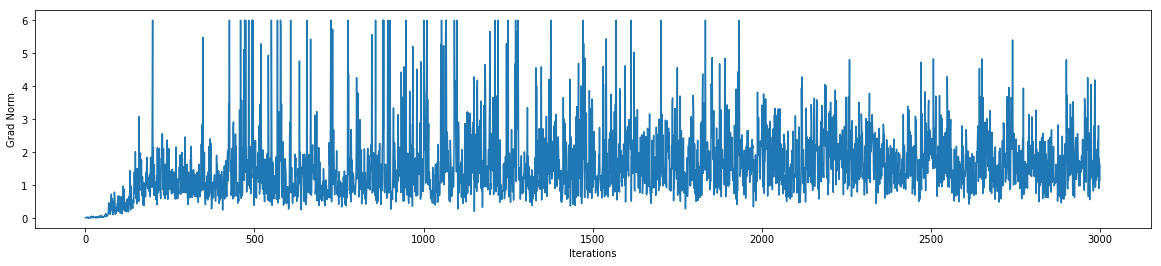

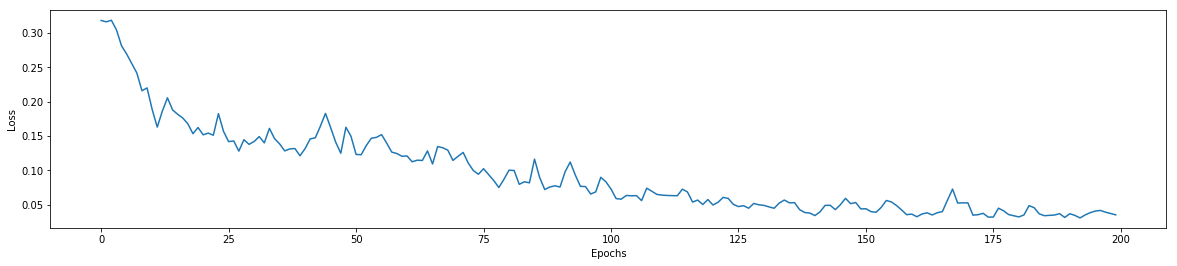

In [0]:
# Plot total norm and loss convergence
plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.plot(total_norm)
plt.figure(figsize=(20,4))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(trloss, label='Train')

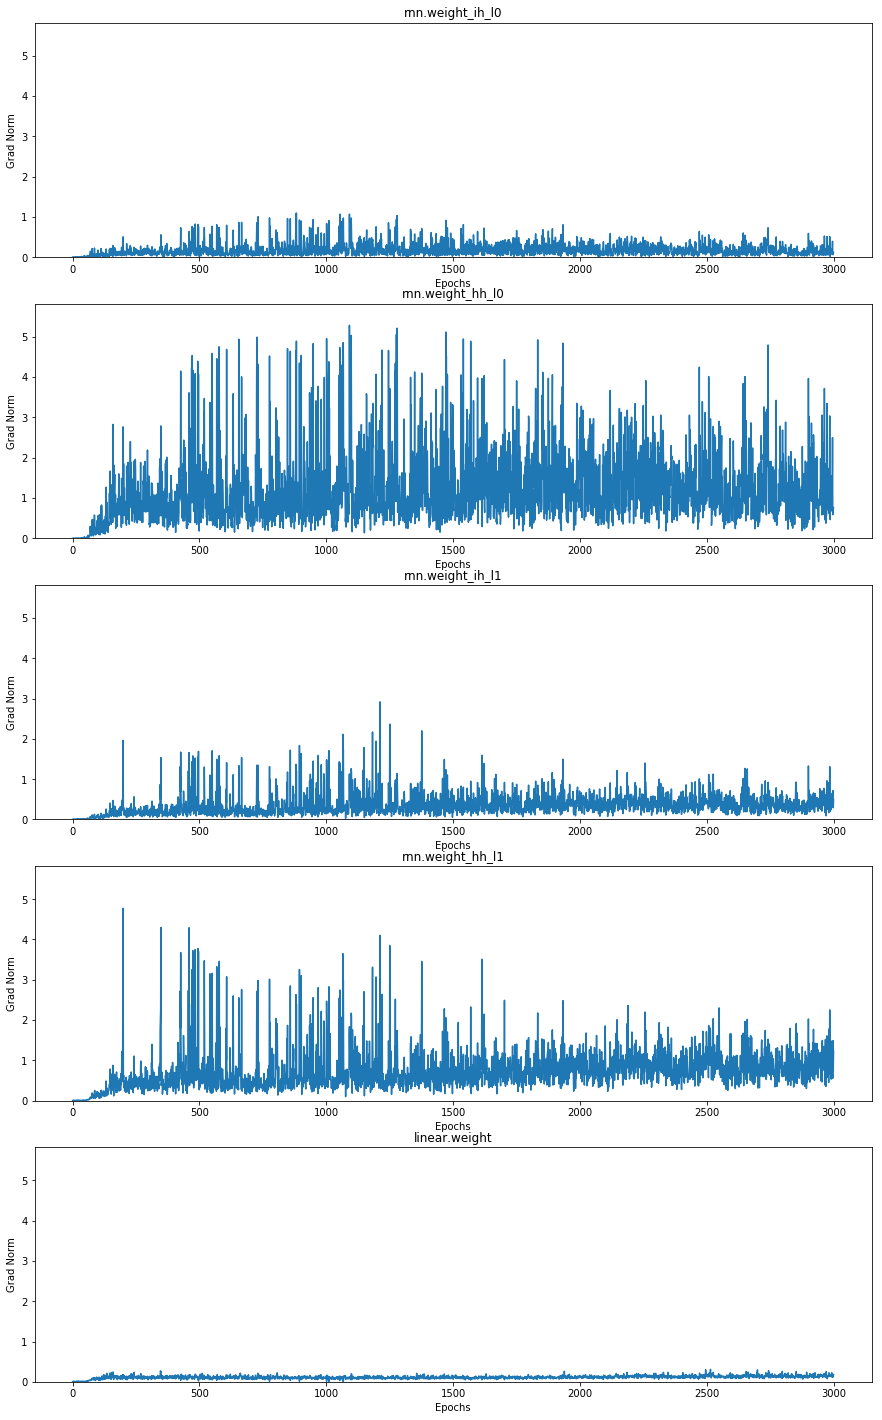

In [0]:
# Plot gradient norm per weight
layers = []
for n, p in net.named_parameters():
  layers.append(n)

fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
grad_norm = np.array(grad_norm)
for i in range(len(grad_norm[0])):
  axs[i].plot(grad_norm[:,i])
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
  axs[i].set_ylim( np.min(grad_norm).cpu().data.numpy(), np.max(grad_norm).cpu().data.numpy()*1.1 )
  

plt.show()

### Clip 10.

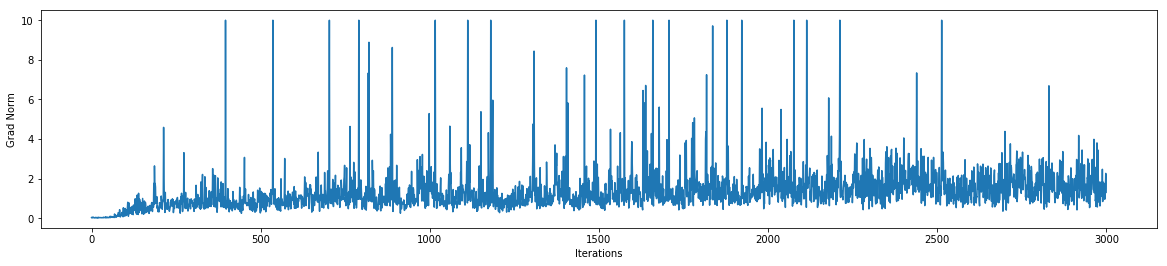

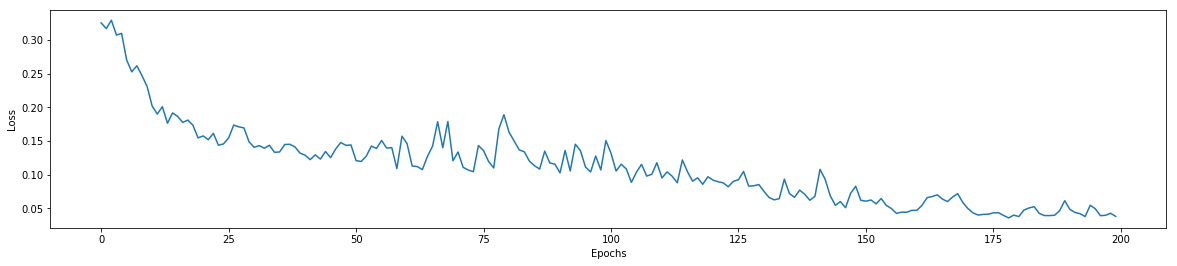

In [0]:
plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.plot(all_total_norm)
plt.figure(figsize=(20,4))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(trloss, label='Train')

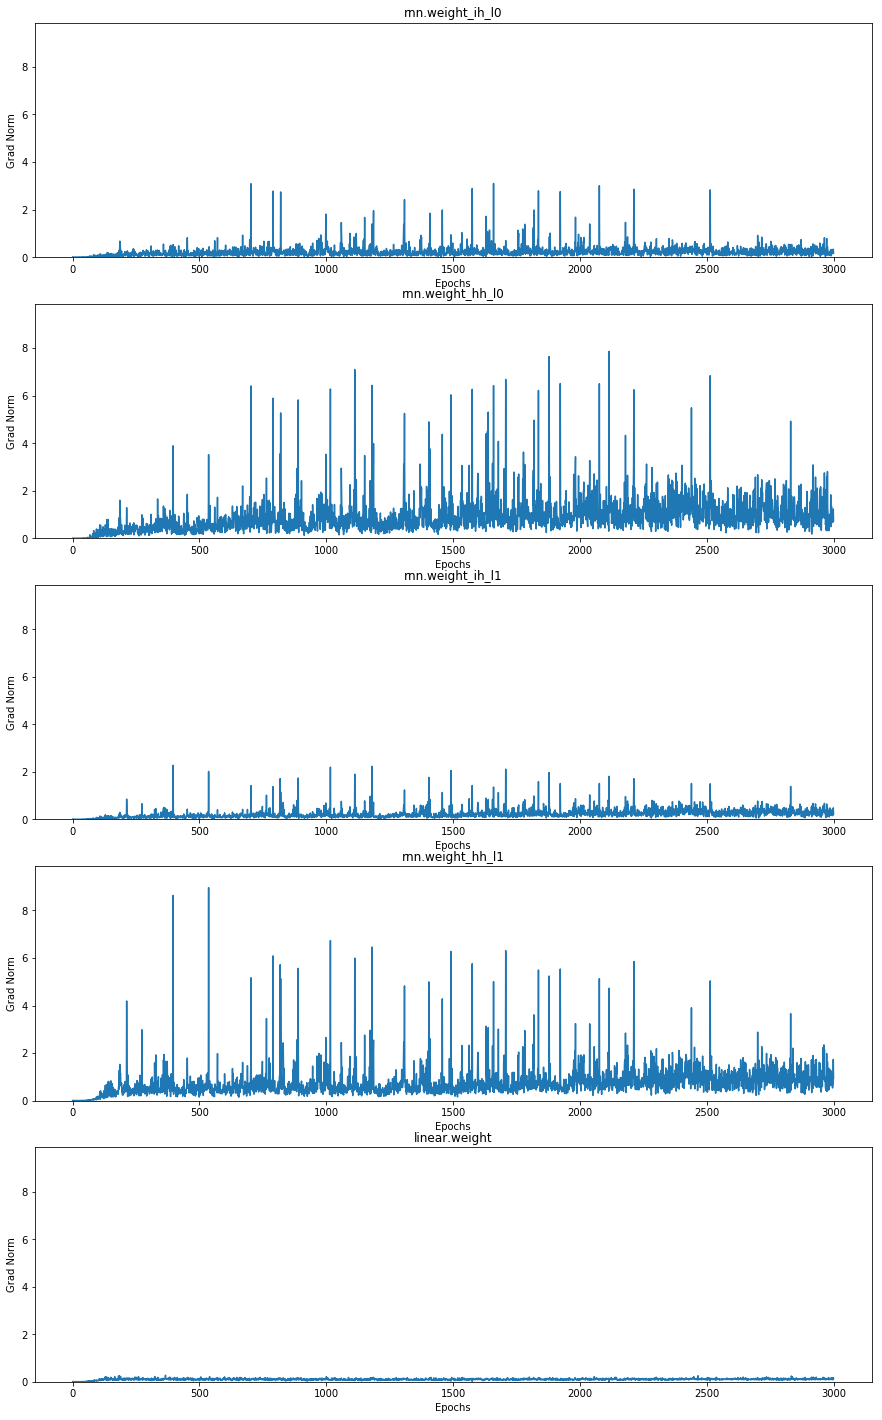

In [0]:
# Gradiente clipping, two layers, 64 units each
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
grad_norm = np.array(grad_norm)
for i in range(len(grad_norm[0])):
#
  axs[i].plot(grad_norm[:,i])
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
  axs[i].set_ylim( np.min(grad_norm).cpu().data.numpy(), np.max(grad_norm).cpu().data.numpy()*1.1 )
  

plt.show()


### No Clip

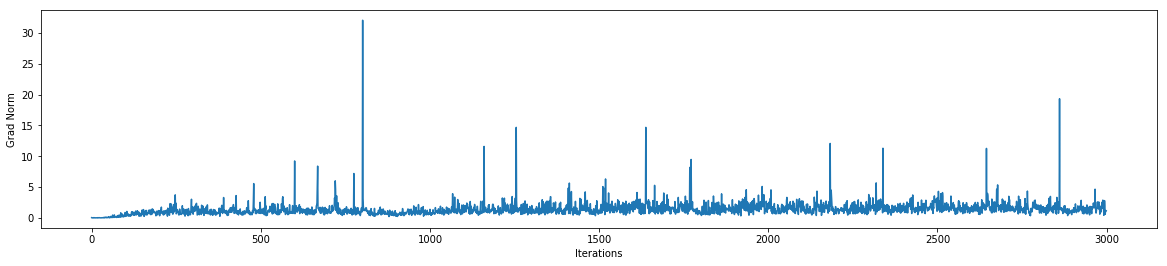

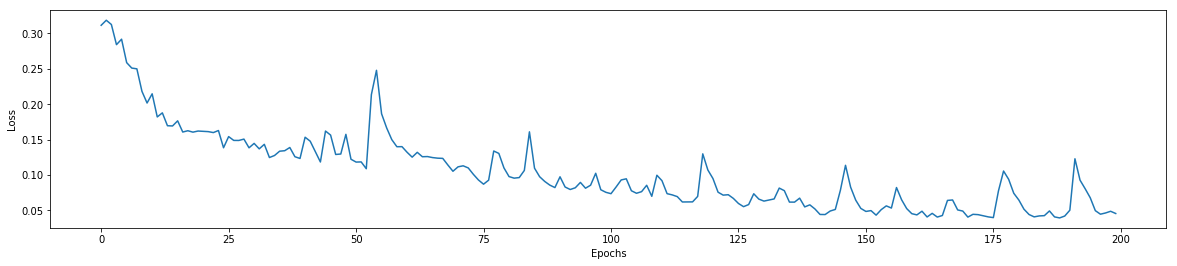

In [0]:
plt.figure(figsize=(20,4))
plt.ylabel('Grad Norm')
plt.xlabel('Iterations')
plt.plot(all_total_norm)
plt.figure(figsize=(20,4))
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(trloss, label='Train')

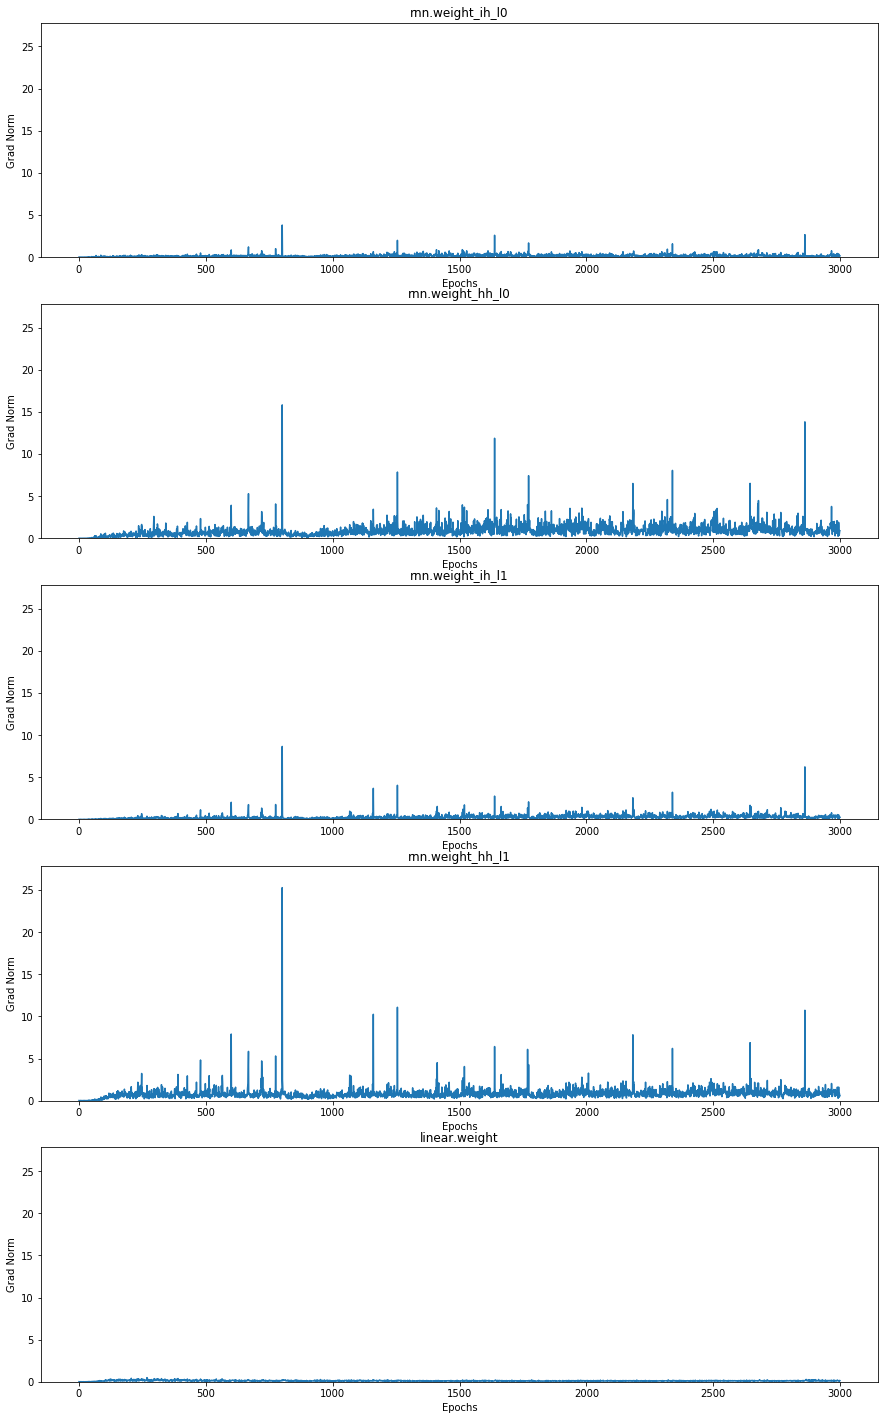

In [0]:
# Gradiente clipping, two layers, 64 units each
fig, axs = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
grad_norm = np.array(grad_norm)
for i in range(len(grad_norm[0])):
#
  axs[i].plot(grad_norm[:,i])
  axs[i].set_ylabel('Grad Norm')
  axs[i].set_xlabel('Epochs')
  axs[i].set_title(layers[i])
  
  axs[i].set_ylim( np.min(grad_norm).cpu().data.numpy(), np.max(grad_norm).cpu().data.numpy()*1.1 )
  

plt.show()


### Comparing Results

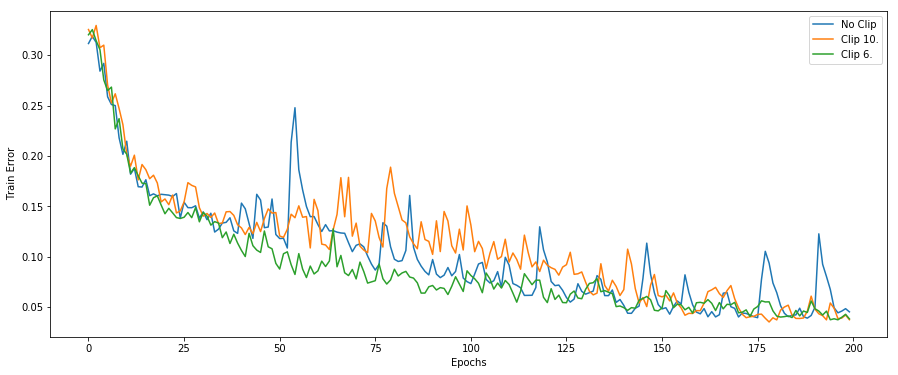

In [0]:
plt.figure(figsize=(15, 6))
plt.plot(bkp['trloss'], label='No Clip')
plt.plot(bkp2[-2]['trloss'], label='Clip 10.')
plt.plot(trloss, label='Clip 6.')
plt.legend()
plt.ylabel('Train Error')
plt.xlabel('Epochs')
plt.show()

## Visualize Results

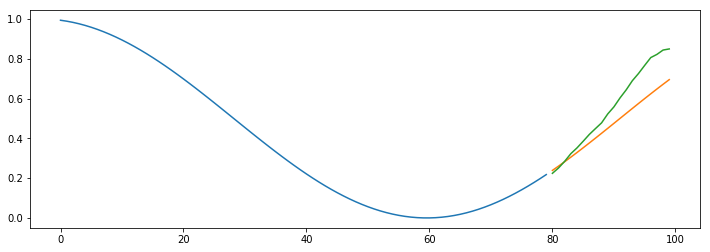

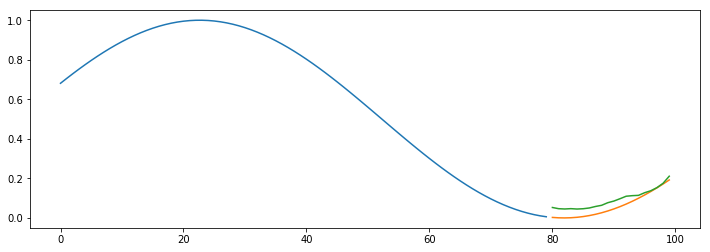

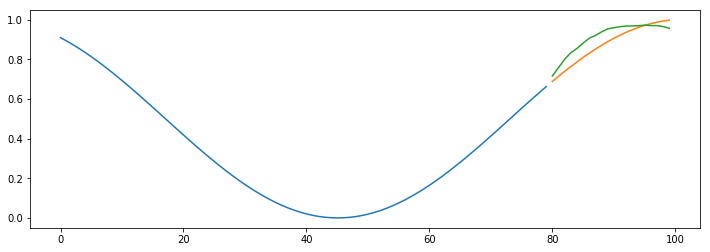

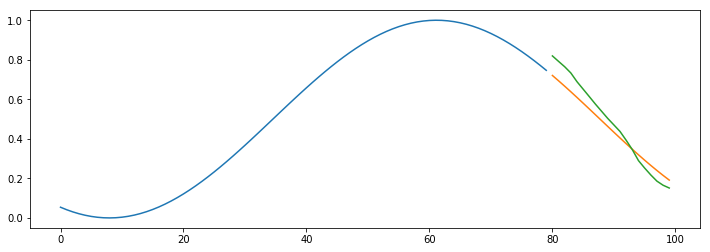

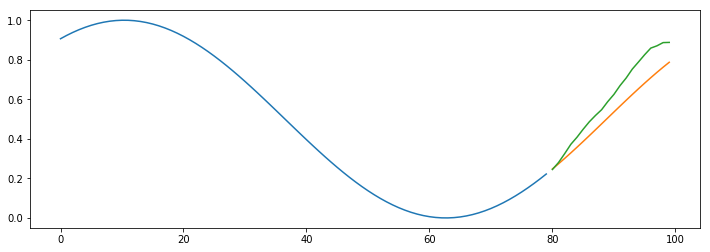

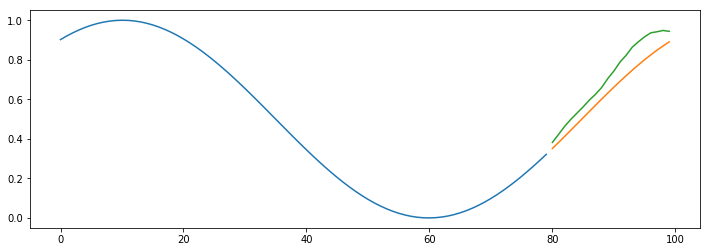

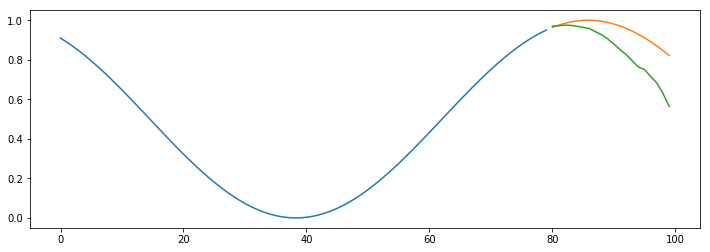

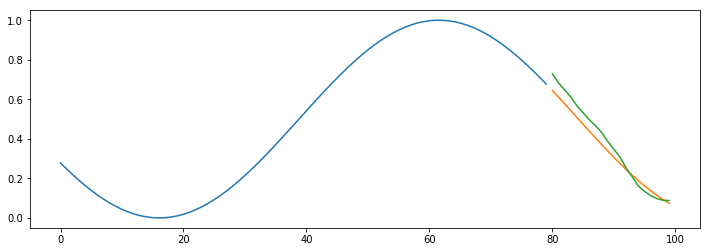

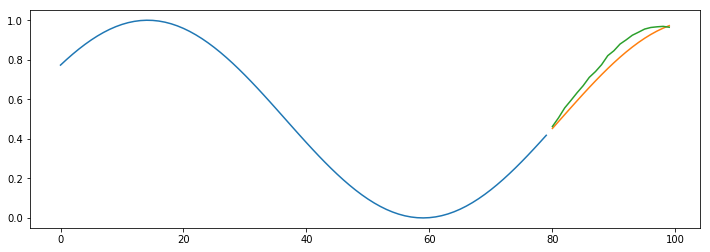

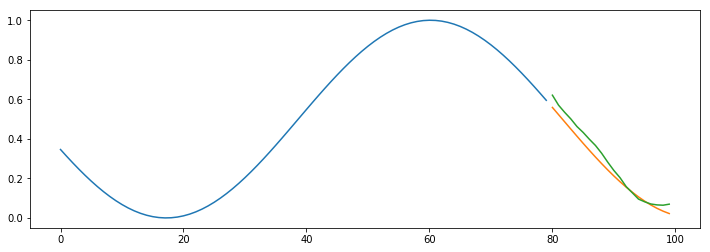

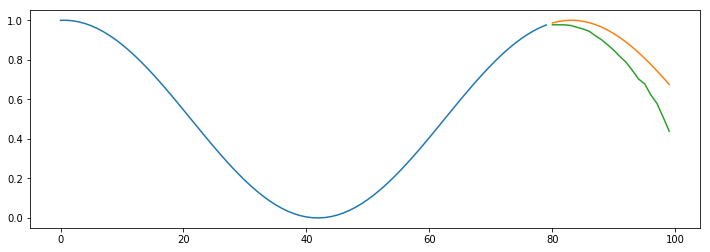

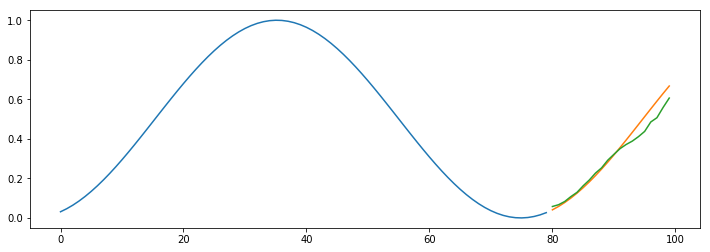

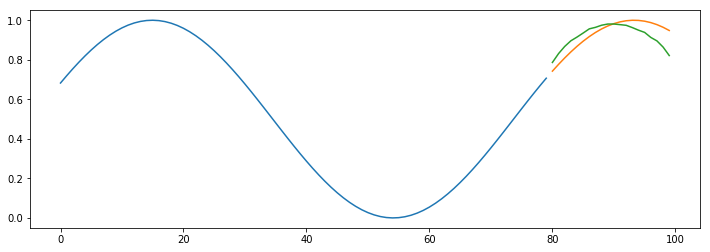

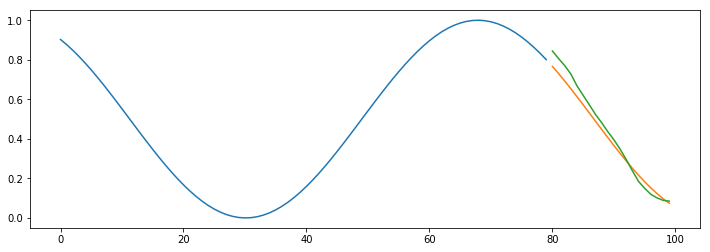

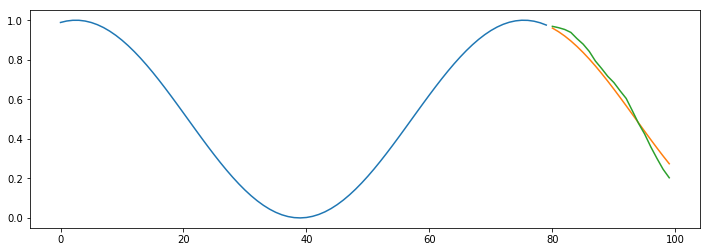

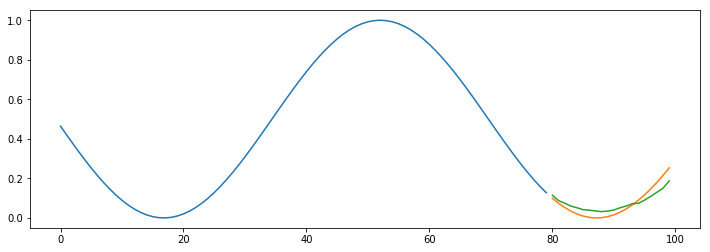

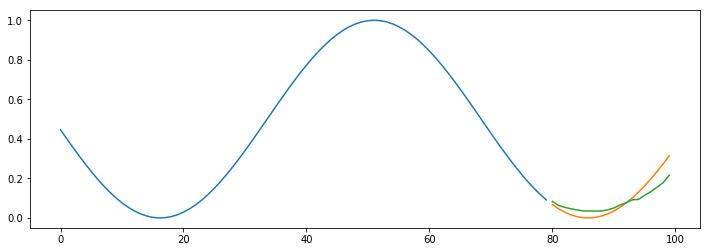

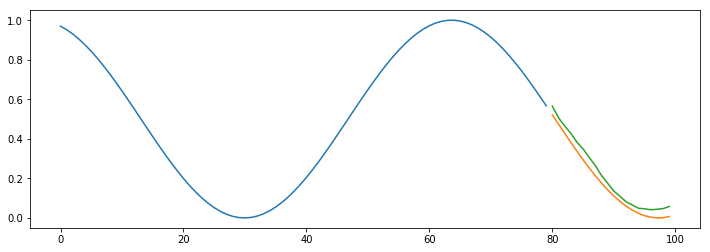

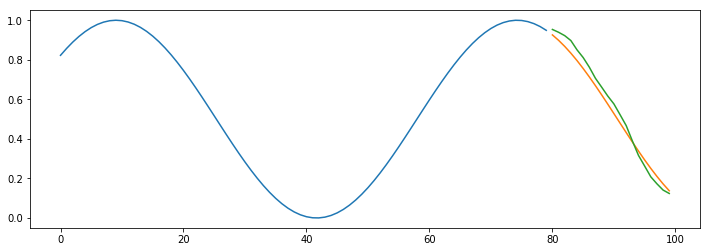

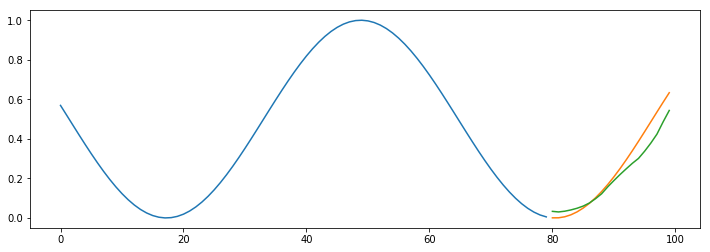

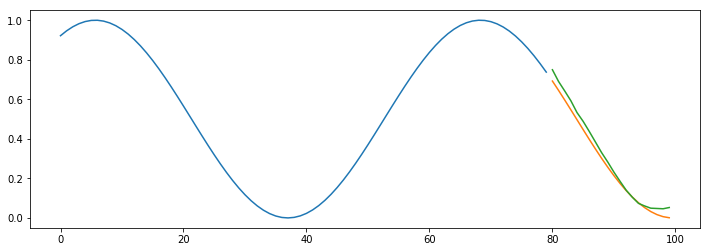

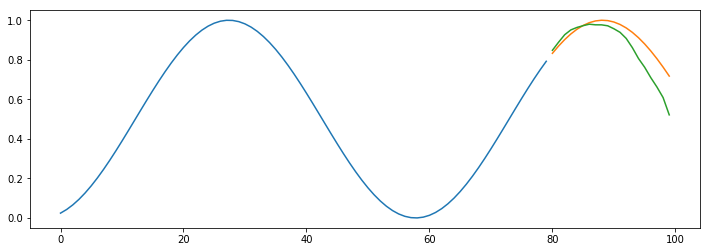

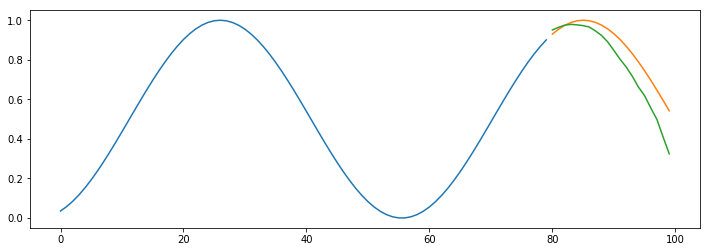

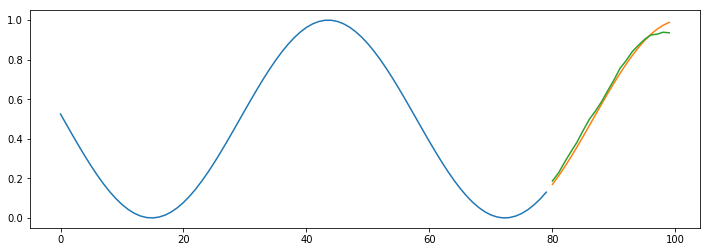

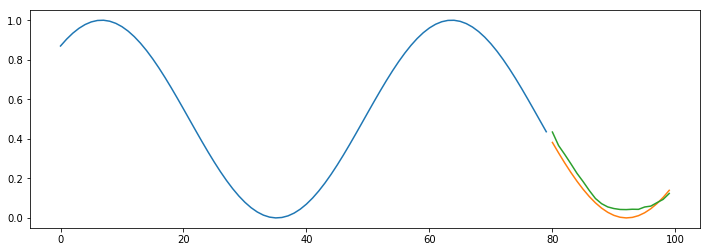

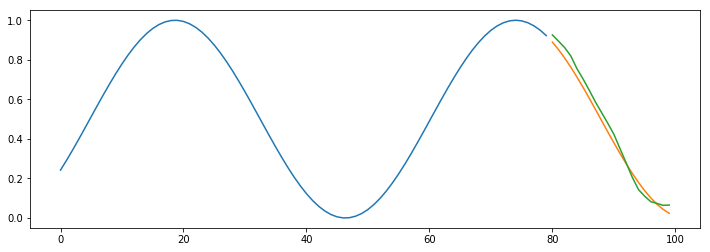

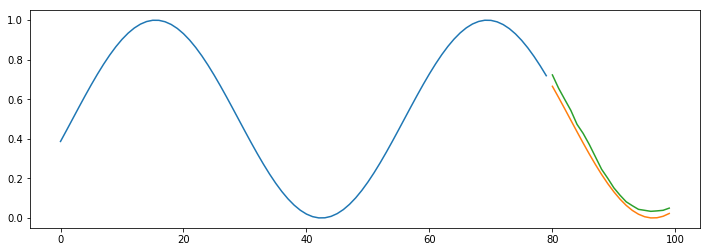

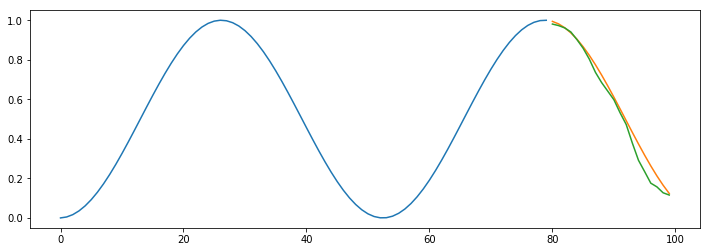

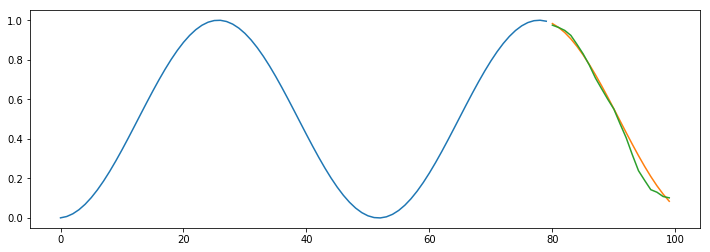

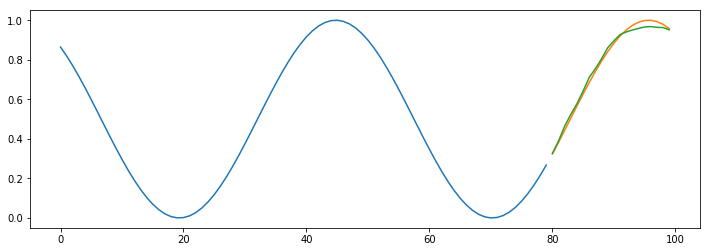

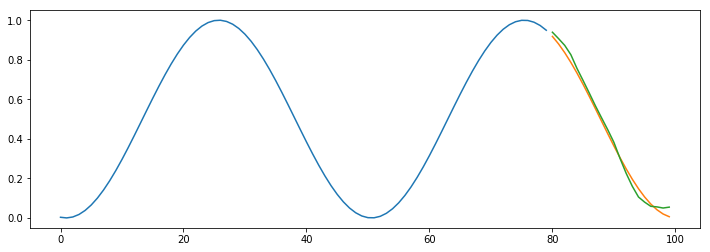

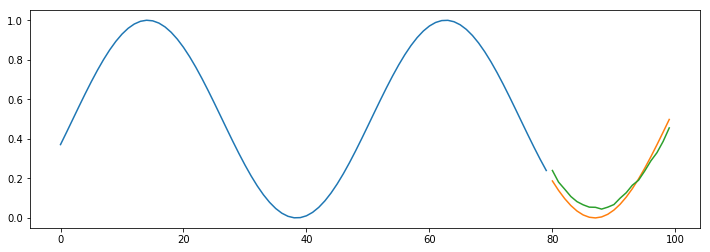

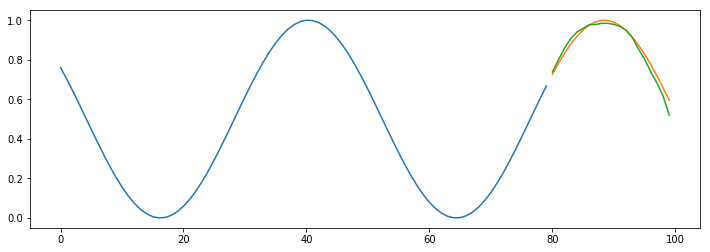

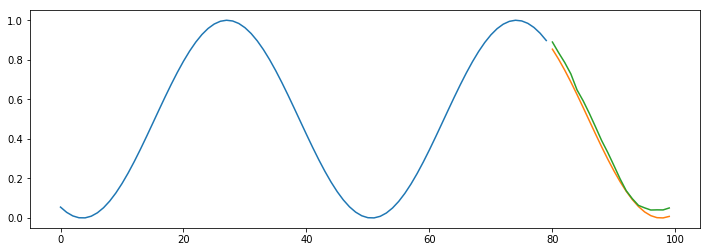

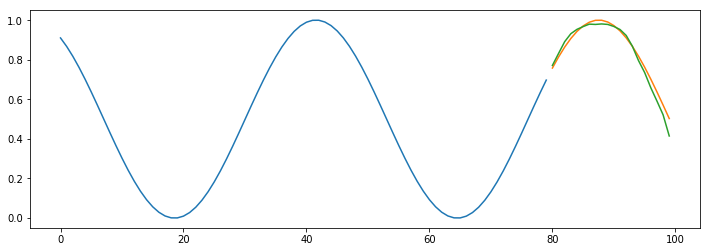

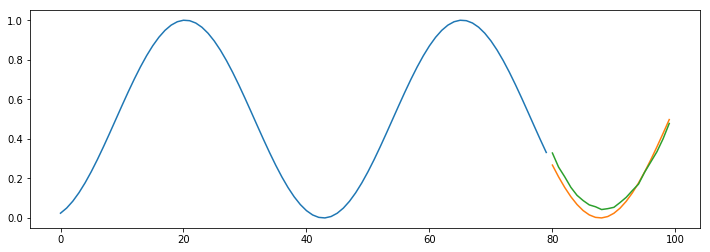

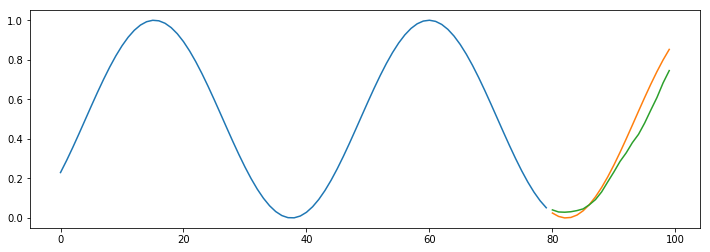

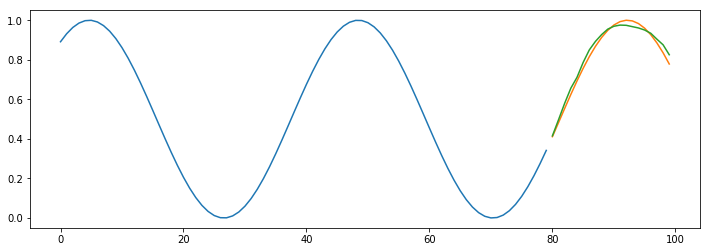

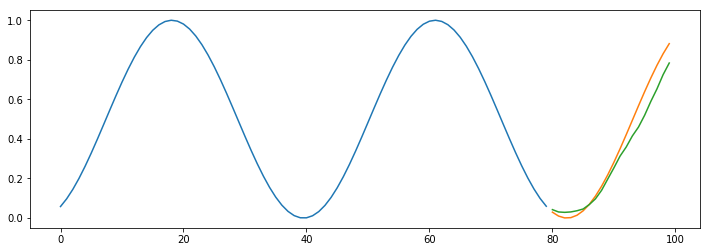

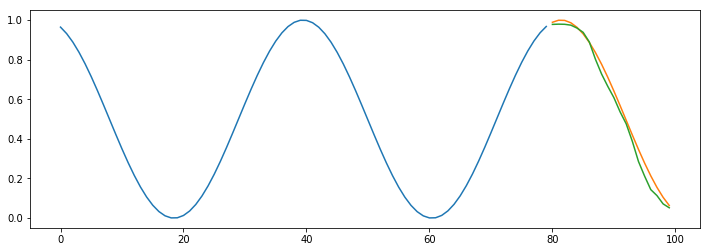

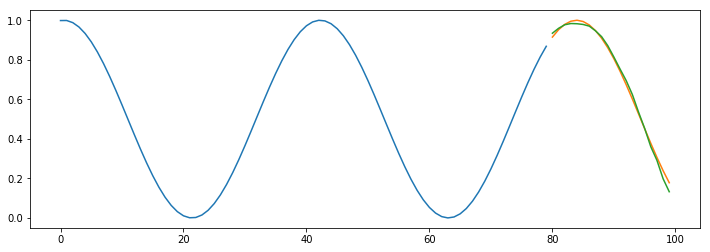

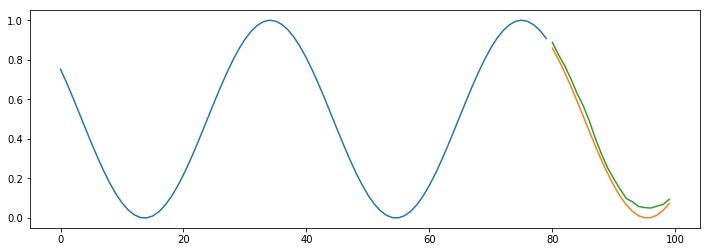

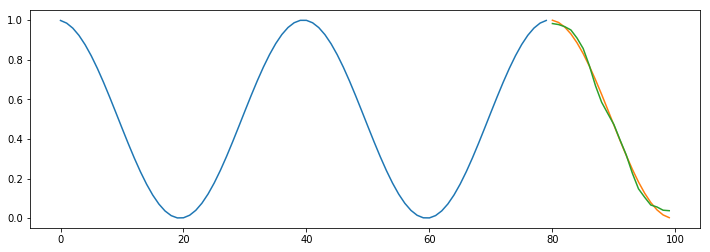

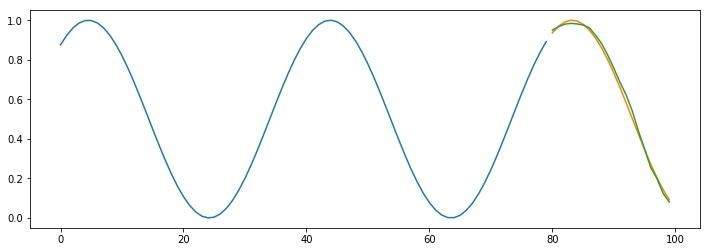

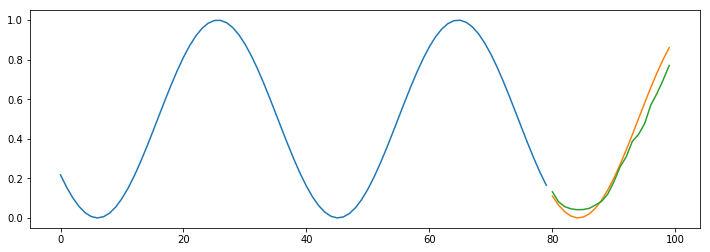

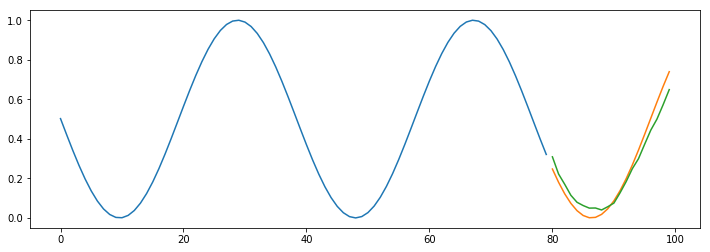

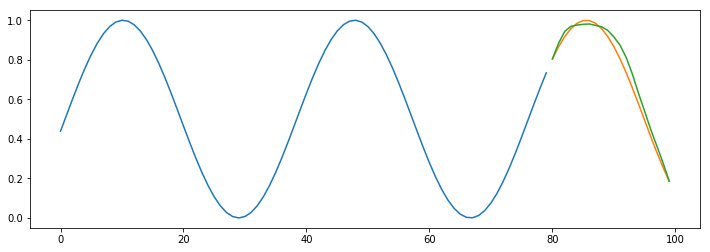

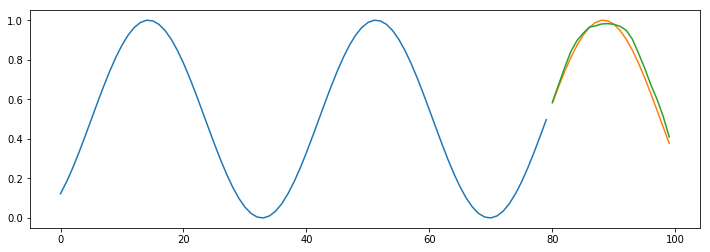

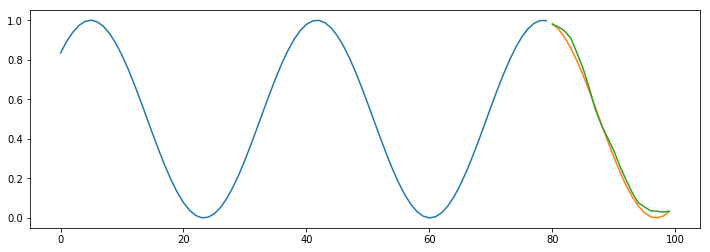

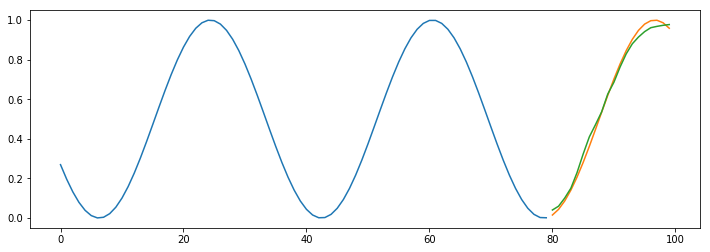

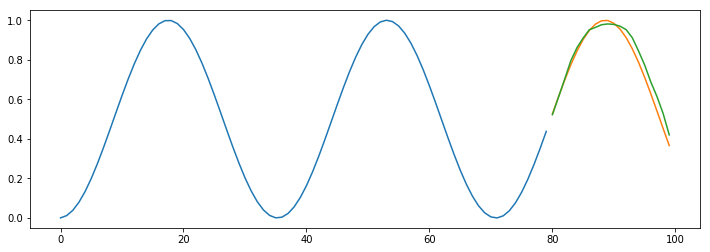

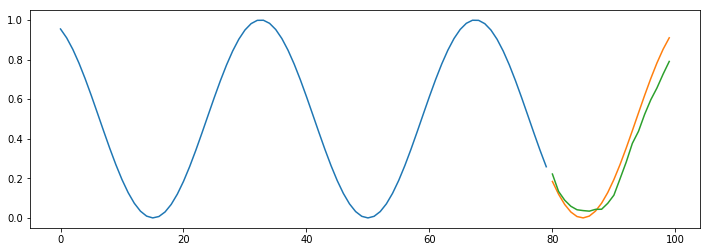

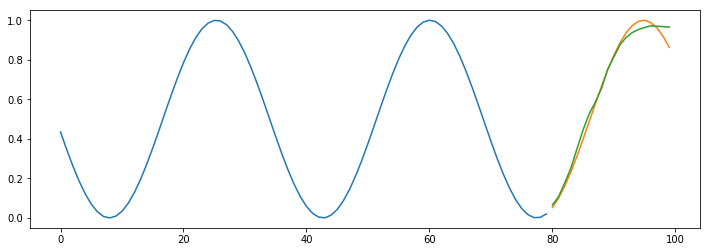

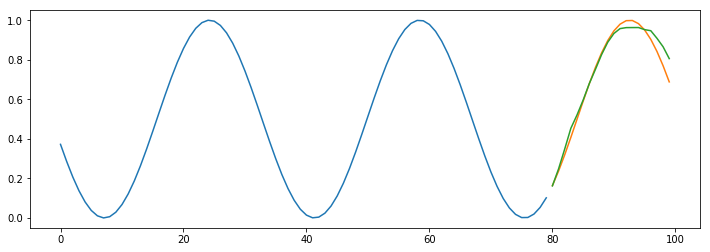

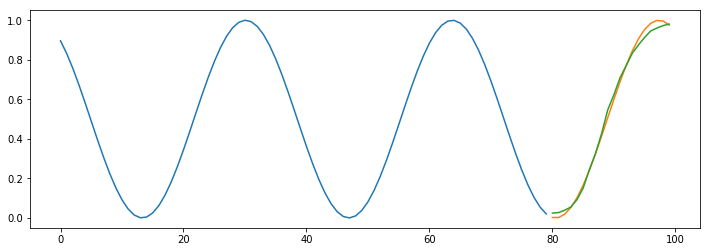

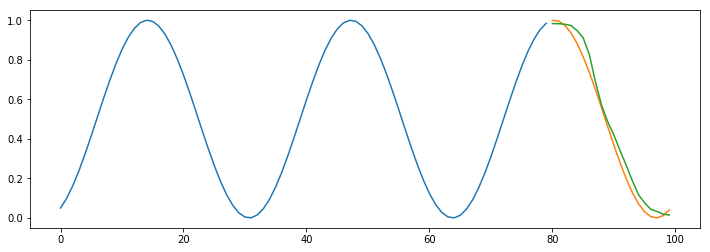

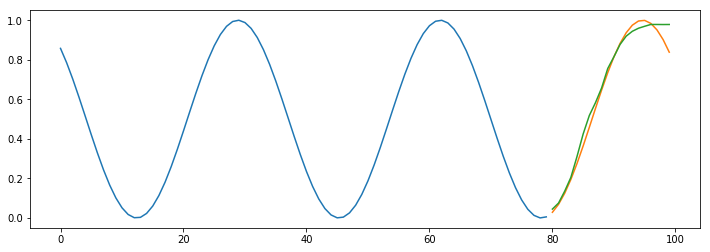

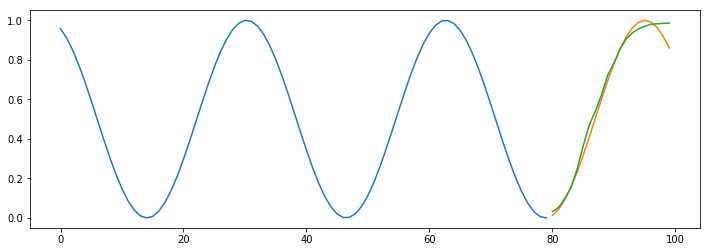

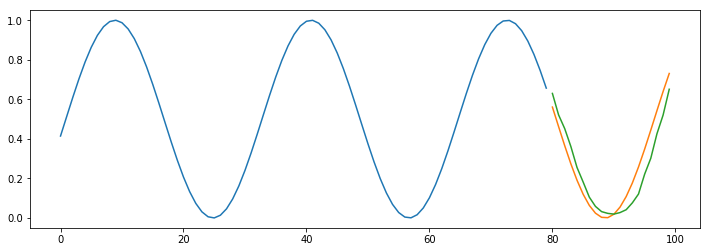

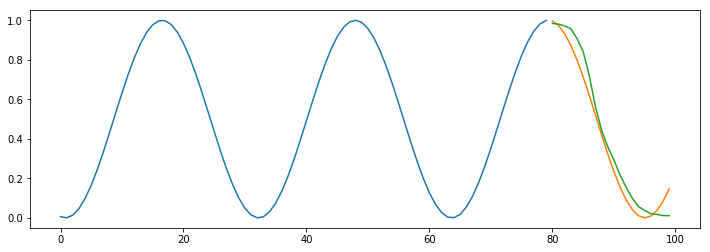

In [0]:
test_vis = DataLoader(test_data, batch_size=args['batch_size'], shuffle=False, num_workers=1)    

losses = []
for inps, labs in test_vis:
    inps = inps.to(args['device'])
    labs = labs.to(args['device'])
    
    outs = net(inps)
    
    for b in range(0,len(inps),3):
      inp = inps.cpu().data.numpy()[b]
      lab = labs.cpu().data.numpy()[b]
      out = outs.cpu().data.numpy()[b]

      plt.figure(figsize=(12,4))
      plt.plot(inp)
      plt.plot(np.arange(len(inp), len(inp)+len(lab)), lab)
      plt.plot(np.arange(len(inp), len(inp)+len(lab)), out)
      plt.show()